# BENCHMARK: Concurrent vs Sequential Stats Processing

Benchmarking comparing concurrent (batch processing), sequential (standard), and legacy endpoints.

## Benchmark Structure

- **BENCHMARK 1**: Concurrent processing (high-volume endpoint, batches)
- **BENCHMARK 2**: Sequential processing (standard endpoint, sequential)
- **BENCHMARK 3**: Legacy endpoint comparison
- **ANALYSIS**: Performance comparison, scaling behavior, recommendations

In [36]:
import time
import pandas as pd
import json
import tempfile
import os
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import logging
# Set up Downloads path for all outputs
downloads_path = Path.home() / "Downloads" / "whisp_benchmarks"
downloads_path.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {downloads_path}")

# Initialize Earth Engine
try:
    ee.Initialize()
    print("Earth Engine initialized")
except:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine authenticated and initialized")



Output directory: C:\Users\Arnell\Downloads\whisp_benchmarks
Earth Engine initialized
Earth Engine initialized


In [37]:
ee.Reset()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
print("Earth Engine reset and initialized with HIGH-VOLUME endpoint for benchmarking")

Earth Engine reset and initialized with HIGH-VOLUME endpoint for benchmarking


In [38]:
# Import WHISP
import openforis_whisp as whisp
from openforis_whisp.advanced_stats import validate_ee_endpoint, check_ee_endpoint
print("WHISP imported with endpoint validation functions")

WHISP imported with endpoint validation functions


In [113]:
state_geom = (ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L1")
    .filter(ee.Filter.inList('gaul1_name', ['Amazonas', 'Mato Grosso', 'Rondônia', 'Pará'])))
bounds = state_geom.geometry().bounds()

# Define benchmark parameters for testing
benchmark_params = {
    'bounds': bounds,
    'areas_ha': [100],  # Different area sizes in hectares
    'polygon_counts': [1000],  # Different numbers of polygons
    'vertex_complexity': [100],  # Simple to complex polygon shapes
    'num_repetitions': 1  # Number of times to repeat each configuration
}

print("Benchmark Parameters Defined:")
print(f"  Areas (ha): {benchmark_params['areas_ha']}")
print(f"  Polygon counts: {benchmark_params['polygon_counts']}")
print(f"  Vertex complexity: {benchmark_params['vertex_complexity']}")
print(f"  Repetitions per config: {benchmark_params['num_repetitions']}")


Benchmark Parameters Defined:
  Areas (ha): [100]
  Polygon counts: [1000]
  Vertex complexity: [100]
  Repetitions per config: 5


In [114]:
# Create Whisp image (reuse if exists, create once for all benchmarks)
print("\n📦 Creating WHISP image for benchmarking...")
iso2_codes = ['br', 'co', 'ci']

try:
    whisp_image_bench = whisp.combine_datasets(national_codes=iso2_codes,auto_recovery=True)
    print(f"✅ Created WHISP image for benchmarking")
except Exception as e:
    print(f"⚠️  No image created: {str(e)}")




📦 Creating WHISP image for benchmarking...
Whisp multiband image compiled
✅ Created WHISP image for benchmarking
Whisp multiband image compiled
✅ Created WHISP image for benchmarking


In [115]:
from openforis_whisp.advanced_stats import validate_ee_endpoint, check_ee_endpoint

In [116]:


# Define Brazil Amazon test region
test_region_states = ["Amazonas", "Mato Grosso", "Rondônia"]
print(f"Test region: Brazil Amazon ({', '.join(test_region_states)})")


print("\nBenchmark Parameters:")
print("  - Concurrent vs Sequential comparison")
print("  - Multiple polygon counts and complexity levels")
print("  - Multiple repetitions for statistical significance")

Test region: Brazil Amazon (Amazonas, Mato Grosso, Rondônia)

Benchmark Parameters:
  - Concurrent vs Sequential comparison
  - Multiple polygon counts and complexity levels
  - Multiple repetitions for statistical significance


In [117]:
precompiled_image = True

In [118]:
try:
    whisp_image_bench
    print("Using existing whisp_image from earlier")
except NameError:
    print("Creating WHISP image for benchmarking...")
    try:
        whisp_image = whisp.combine_datasets()
        print("Created WHISP image for benchmarking")
    except Exception as e:
        print(f"Error creating image: {e}")
        whisp_image = None

print("Helper function defined for test data generation")

Using existing whisp_image from earlier
Helper function defined for test data generation


In [119]:
# Helper function to generate test GeoJSON
def generate_test_geojson(num_polygons, area_ha, num_vertices, bounds):
    """Generate random test GeoJSON within bounds"""
    try:
        geojson = whisp.generate_test_polygons(
            bounds=bounds,
            num_polygons=num_polygons,
            min_area_ha=area_ha * 0.9,
            max_area_ha=area_ha * 1.1,
            min_number_vert=num_vertices,
            max_number_vert=num_vertices,
        )
        
        # Save to temp file
        import tempfile
        temp_fd, temp_path = tempfile.mkstemp(suffix='.geojson', text=True)
        try:
            with os.fdopen(temp_fd, 'w') as f:
                json.dump(geojson, f)
        except:
            os.close(temp_fd)
            raise
        
        return temp_path, geojson
    except Exception as e:
        print(f"Error generating test data: {e}")
        raise

# Set up logger
logger = logging.getLogger("whisp-concurrent")
logger.setLevel(logging.INFO)

# Get Brazil geometry for testing
try:
    fc = (ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L1")
    .filter(ee.Filter.inList('gaul1_name', test_region_states)))
    geom = fc.geometry().bounds()
    print("\n✅ Brazil regions geometry loaded")
except Exception as e:
    print(f"Warning: Could not load Brazil geometry: {e}")
    geom = None

print("Helper function defined for test data generation")


✅ Brazil regions geometry loaded
Helper function defined for test data generation


In [120]:
# ============================================================================
# PRE-BENCHMARK CHECK: Validate High-Volume Endpoint
# ============================================================================
print("\n" + "="*80)
print("PRE-BENCHMARK CHECK: Endpoint Validation")
print("="*80)

# Check and display current endpoint
api_url = str(ee.data._cloud_api_base_url)
current_endpoint = "HIGH-VOLUME" if "highvolume" in api_url.lower() else "STANDARD"
print(f"\n📍 Current Earth Engine Endpoint: {current_endpoint}")
print(f"   URL: {api_url}")

# Validate that we're using high-volume endpoint for concurrent
try:
    validate_ee_endpoint("high-volume", raise_error=True)
    print("\n✅ High-volume endpoint validated - concurrent benchmark can proceed")
except RuntimeError as e:
    print(f"\n❌ Endpoint validation FAILED:")
    print(f"{e}")
    print("\n🔧 Attempting to fix by initializing high-volume endpoint...")
    ee.Reset()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print("✅ High-volume endpoint re-initialized")


PRE-BENCHMARK CHECK: Endpoint Validation

📍 Current Earth Engine Endpoint: HIGH-VOLUME
   URL: https://earthengine-highvolume.googleapis.com

✅ High-volume endpoint validated - concurrent benchmark can proceed


In [ ]:
# ============================================================================
# BENCHMARK 1: CONCURRENT METHOD (High-Volume Endpoint)
# ============================================================================
print("\n" + "="*80)
print("BENCHMARK 1: CONCURRENT METHOD (High-Volume Endpoint)")
print(f"Running {benchmark_params['num_repetitions']} repetitions per test")
print("="*80)

benchmark_results_concurrent = []

# Iterate through all parameter combinations with repetitions
total_combinations = (len(benchmark_params['areas_ha']) * 
                      len(benchmark_params['polygon_counts']) * 
                      len(benchmark_params['vertex_complexity']))
total_tests = total_combinations * benchmark_params['num_repetitions']
test_num = 0

for area_ha in benchmark_params['areas_ha']:
    for num_polygons in benchmark_params['polygon_counts']:
        for num_vertices in benchmark_params['vertex_complexity']:
            # Run each configuration multiple times
            for rep in range(benchmark_params['num_repetitions']):
                test_num += 1
                
                # Generate test data
                geojson_path, geojson_data = generate_test_geojson(
                    num_polygons=num_polygons,
                    area_ha=area_ha,
                    num_vertices=num_vertices,
                    bounds=geom
                )
                
                # Run concurrent processing with timing
                start_time = time.time()
                try:
                    df_result = whisp.whisp_stats_geojson_to_df_concurrent(
                        input_geojson_filepath=geojson_path,
                        national_codes=iso2_codes,
                        add_metadata_server=False,
                        whisp_image=whisp_image_bench if precompiled_image == True else None,
                    )
                    elapsed_time = time.time() - start_time
                    status = "✅"
                    error_msg = None
                    rows_processed = df_result.shape[0]
                    
                except Exception as e:
                    elapsed_time = time.time() - start_time
                    status = "❌"
                    error_msg = str(e)
                    rows_processed = 0
                
                # Store results
                benchmark_results_concurrent.append({
                    'method': 'Concurrent',
                    'area_ha': area_ha,
                    'num_polygons': num_polygons,
                    'num_vertices': num_vertices,
                    'repetition': rep + 1,
                    'total_features': num_polygons,
                    'rows_processed': rows_processed,
                    'time_seconds': elapsed_time,
                    'time_per_polygon': elapsed_time / num_polygons if num_polygons > 0 else 0,
                    'status': status,
                    'error': error_msg
                })
                
                # Show progress (only show every 3rd rep to reduce clutter)
                if rep == benchmark_params['num_repetitions'] - 1:
                    print(f"[{test_num:3d}/{total_tests}] {status} Area: {area_ha:3d}ha | " + 
                          f"Polygons: {num_polygons:3d} | Vertices: {num_vertices:5d} | " + 
                          f"Rep {rep+1}/{benchmark_params['num_repetitions']} | Time: {elapsed_time:7.2f}s")
                
                # Cleanup - try multiple times as file may be locked
                import time as time_module
                time_module.sleep(0.1)  # Give time for file to be released
                for attempt in range(3):
                    try:
                        os.remove(geojson_path)
                        break
                    except (PermissionError, FileNotFoundError):
                        if attempt < 2:
                            time_module.sleep(0.2)
                        elif os.path.exists(geojson_path):
                            pass  # File may be locked, skip for now

print(f"\n✅ Concurrent benchmarking complete ({test_num} tests with {benchmark_params['num_repetitions']} repetitions)")


BENCHMARK 1: CONCURRENT METHOD (High-Volume Endpoint)
Running 5 repetitions per test
[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 

2025-11-06 18:19:52,465 - INFO - Loaded 1,000 features
2025-11-06 18:19:52,497 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:19:52,497 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:20:16,888 - INFO - Progress: 25/100 (25%) | Elapsed: 24s | ETA: 1.2m
2025-11-06 18:20:16,888 - INFO - Progress: 25/100 (25%) | Elapsed: 24s | ETA: 1.2m
2025-11-06 18:20:28,344 - INFO - Progress: 50/100 (50%) | Elapsed: 36s | ETA: 36s
2025-11-06 18:20:28,344 - INFO - Progress: 50/100 (50%) | Elapsed: 36s | ETA: 36s
2025-11-06 18:20:45,947 - INFO - Progress: 75/100 (75%) | Elapsed: 53s | ETA: 18s
2025-11-06 18:20:45,947 - INFO - Progress: 75/100 (75%) | Elapsed: 53s | ETA: 18s
2025-11-06 18:21:02,114 - INFO - Progress: 100/100 (100%) | Total time: 1.2m
2025-11-06 18:21:02,114 - INFO - Progress: 100/100 (100%) | Total time: 1.2m
2025-11-06 18:21:02,130 - INFO - Processing complete: 100/100 batches in 1.2m
2025-11-06 18:21:02,130 - INFO - Processing complete: 100/100 batches i

[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 750/1000 polygons (75%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generat

2025-11-06 18:21:09,556 - INFO - Loaded 1,000 features
2025-11-06 18:21:09,604 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:21:09,604 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:21:33,035 - INFO - Progress: 25/100 (25%) | Elapsed: 23s | ETA: 1.2m
2025-11-06 18:21:33,035 - INFO - Progress: 25/100 (25%) | Elapsed: 23s | ETA: 1.2m
2025-11-06 18:21:47,329 - INFO - Progress: 50/100 (50%) | Elapsed: 38s | ETA: 38s
2025-11-06 18:21:47,329 - INFO - Progress: 50/100 (50%) | Elapsed: 38s | ETA: 38s
2025-11-06 18:21:59,736 - INFO - Progress: 75/100 (75%) | Elapsed: 50s | ETA: 17s
2025-11-06 18:21:59,736 - INFO - Progress: 75/100 (75%) | Elapsed: 50s | ETA: 17s
2025-11-06 18:22:21,283 - INFO - Progress: 100/100 (100%) | Total time: 1.2m
2025-11-06 18:22:21,283 - INFO - Progress: 100/100 (100%) | Total time: 1.2m
2025-11-06 18:22:21,308 - INFO - Processing complete: 100/100 batches in 1.2m
2025-11-06 18:22:21,308 - INFO - Processing complete: 100/100 batches i

[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 750/1000 polygons (75%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generat

2025-11-06 18:22:27,496 - INFO - Loaded 1,000 features
2025-11-06 18:22:27,537 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:22:27,537 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:22:51,796 - INFO - Progress: 25/100 (25%) | Elapsed: 24s | ETA: 1.2m
2025-11-06 18:22:51,796 - INFO - Progress: 25/100 (25%) | Elapsed: 24s | ETA: 1.2m
2025-11-06 18:23:02,617 - INFO - Progress: 50/100 (50%) | Elapsed: 35s | ETA: 35s
2025-11-06 18:23:02,617 - INFO - Progress: 50/100 (50%) | Elapsed: 35s | ETA: 35s
2025-11-06 18:23:15,762 - INFO - Progress: 75/100 (75%) | Elapsed: 48s | ETA: 16s
2025-11-06 18:23:15,762 - INFO - Progress: 75/100 (75%) | Elapsed: 48s | ETA: 16s
2025-11-06 18:23:33,373 - INFO - Progress: 100/100 (100%) | Total time: 1.1m
2025-11-06 18:23:33,389 - INFO - Processing complete: 100/100 batches in 1.1m
2025-11-06 18:23:33,373 - INFO - Progress: 100/100 (100%) | Total time: 1.1m
2025-11-06 18:23:33,389 - INFO - Processing complete: 100/100 batches i

[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 750/1000 polygons (75%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generat

2025-11-06 18:23:39,722 - INFO - Loaded 1,000 features
2025-11-06 18:23:39,754 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:23:39,754 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:24:02,024 - INFO - Progress: 25/100 (25%) | Elapsed: 22s | ETA: 1.1m
2025-11-06 18:24:02,024 - INFO - Progress: 25/100 (25%) | Elapsed: 22s | ETA: 1.1m
2025-11-06 18:24:16,751 - INFO - Progress: 50/100 (50%) | Elapsed: 37s | ETA: 37s
2025-11-06 18:24:16,751 - INFO - Progress: 50/100 (50%) | Elapsed: 37s | ETA: 37s
2025-11-06 18:24:28,595 - INFO - Progress: 75/100 (75%) | Elapsed: 49s | ETA: 16s
2025-11-06 18:24:28,595 - INFO - Progress: 75/100 (75%) | Elapsed: 49s | ETA: 16s
2025-11-06 18:24:44,187 - INFO - Progress: 100/100 (100%) | Total time: 1.1m
2025-11-06 18:24:44,187 - INFO - Progress: 100/100 (100%) | Total time: 1.1m
2025-11-06 18:24:44,204 - INFO - Processing complete: 100/100 batches in 1.1m
2025-11-06 18:24:44,204 - INFO - Processing complete: 100/100 batches i

[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 1000 test polygons with 100-100 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/1000 polygons (25%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 500/1000 polygons (50%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 750/1000 polygons (75%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generat

2025-11-06 18:24:50,531 - INFO - Loaded 1,000 features
2025-11-06 18:24:50,574 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:24:50,574 - INFO - Processing 1,000 features in 100 batches
2025-11-06 18:25:15,569 - INFO - Progress: 25/100 (25%) | Elapsed: 25s | ETA: 1.2m
2025-11-06 18:25:15,569 - INFO - Progress: 25/100 (25%) | Elapsed: 25s | ETA: 1.2m


In [ ]:
# ============================================================================
# BACKUP: Save Concurrent Results
# ============================================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_concurrent_backup = pd.DataFrame(benchmark_results_concurrent)
concurrent_backup_file = downloads_path / f"benchmark_concurrent_{timestamp}.csv"
df_concurrent_backup.to_csv(concurrent_backup_file, index=False)
print(f"\n💾 Concurrent results backed up: {concurrent_backup_file}")
print(f"   Rows: {len(df_concurrent_backup)}")



💾 Concurrent results backed up: C:\Users\Arnell\Downloads\whisp_benchmarks\benchmark_concurrent_20251106_181125.csv
   Rows: 4


In [ ]:
# ============================================================================
# SWITCH TO STANDARD ENDPOINT for non-concurrent and legacy tests
# ============================================================================
print("\n" + "="*80)
print("SWITCHING ENDPOINTS: Resetting to Standard for non-concurrent tests")
print("="*80)

ee.Reset()
print("✅ Earth Engine reset")

try:
    ee.Initialize(opt_url='https://earthengine.googleapis.com')
    print("✅ Initialized with standard endpoint")
except Exception:
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine.googleapis.com')
    print("✅ Authenticated and initialized with standard endpoint")

# Verify endpoint
api_url = str(ee.data._cloud_api_base_url)
print(f"📍 Current endpoint: {'HIGH-VOLUME' if 'highvolume' in api_url else 'STANDARD'}")



SWITCHING ENDPOINTS: Resetting to Standard for non-concurrent tests
✅ Earth Engine reset
✅ Initialized with standard endpoint
📍 Current endpoint: STANDARD
✅ Initialized with standard endpoint
📍 Current endpoint: STANDARD


In [ ]:
# ============================================================================
# BENCHMARK 2: SEQUENTIAL METHOD (Standard Endpoint)
# ============================================================================
print("\n" + "="*80)
print("BENCHMARK 2: SEQUENTIAL METHOD (Standard Endpoint)")
print(f"Running {benchmark_params['num_repetitions']} repetitions per test")
print("="*80)

benchmark_results_sequential = []

# Iterate through all parameter combinations with repetitions
total_combinations = (len(benchmark_params['areas_ha']) * 
                      len(benchmark_params['polygon_counts']) * 
                      len(benchmark_params['vertex_complexity']))
total_tests = total_combinations * benchmark_params['num_repetitions']
test_num = 0

for area_ha in benchmark_params['areas_ha']:
    for num_polygons in benchmark_params['polygon_counts']:
        for num_vertices in benchmark_params['vertex_complexity']:
            # Run each configuration multiple times
            for rep in range(benchmark_params['num_repetitions']):
                test_num += 1
                
                # Generate test data
                geojson_path, geojson_data = generate_test_geojson(
                    num_polygons=num_polygons,
                    area_ha=area_ha,
                    num_vertices=num_vertices,
                    bounds=geom
                )
                
                # Run sequential processing with timing
                start_time = time.time()
                try:
                    df_result = whisp.whisp_formatted_stats_geojson_to_df_sequential(
                        input_geojson_filepath=geojson_path,
                        national_codes=iso2_codes,
                        add_metadata_client_side=True,
                        logger=logger,
                    )
                    elapsed_time = time.time() - start_time
                    status = "✅"
                    error_msg = None
                    rows_processed = df_result.shape[0]
                    
                except Exception as e:
                    elapsed_time = time.time() - start_time
                    status = "❌"
                    error_msg = str(e)
                    rows_processed = 0
                
                # Store results
                benchmark_results_sequential.append({
                    'method': 'Sequential',
                    'area_ha': area_ha,
                    'num_polygons': num_polygons,
                    'num_vertices': num_vertices,
                    'repetition': rep + 1,
                    'total_features': num_polygons,
                    'rows_processed': rows_processed,
                    'time_seconds': elapsed_time,
                    'time_per_polygon': elapsed_time / num_polygons if num_polygons > 0 else 0,
                    'status': status,
                    'error': error_msg
                })
                
                # Show progress (only show every 3rd rep to reduce clutter)
                if rep == benchmark_params['num_repetitions'] - 1:
                    print(f"[{test_num:3d}/{total_tests}] {status} Area: {area_ha:3d}ha | " + 
                          f"Polygons: {num_polygons:3d} | Vertices: {num_vertices:5d} | " + 
                          f"Rep {rep+1}/{benchmark_params['num_repetitions']} | Time: {elapsed_time:7.2f}s")
                
                # Cleanup - try multiple times as file may be locked
                import time as time_module
                time_module.sleep(0.1)  # Give time for file to be released
                for attempt in range(3):
                    try:
                        os.remove(geojson_path)
                        break
                    except (PermissionError, FileNotFoundError):
                        if attempt < 2:
                            time_module.sleep(0.2)
                        elif os.path.exists(geojson_path):
                            pass  # File may be locked, skip for now

print(f"\n✅ Sequential benchmarking complete ({test_num} tests with {benchmark_params['num_repetitions']} repetitions)")


BENCHMARK 2: SEQUENTIAL METHOD (Standard Endpoint)
Running 2 repetitions per test
[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0, Actual: 5.2-7.7
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, 

2025-11-06 18:11:30,800 - INFO - Loaded 200 features
2025-11-06 18:11:31,609 - INFO - Processing with Earth Engine...
2025-11-06 18:11:31,609 - INFO - Processing with Earth Engine...
2025-11-06 18:11:41,612 - INFO - Processed 200 features
2025-11-06 18:11:41,612 - INFO - Processed 200 features
2025-11-06 18:11:41,751 - INFO - Sequential processing + formatting + validation complete
2025-11-06 18:11:41,751 - INFO - Sequential processing + formatting + validation complete


[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0, Actual: 5.2-7.6
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Request

2025-11-06 18:11:44,733 - INFO - Loaded 200 features
2025-11-06 18:11:45,539 - INFO - Processing with Earth Engine...
2025-11-06 18:11:45,539 - INFO - Processing with Earth Engine...
2025-11-06 18:11:54,851 - INFO - Processed 200 features
2025-11-06 18:11:54,851 - INFO - Processed 200 features
2025-11-06 18:11:55,137 - INFO - Sequential processing + formatting + validation complete
2025-11-06 18:11:55,137 - INFO - Sequential processing + formatting + validation complete


[  2/4] ✅ Area:  10ha | Polygons: 200 | Vertices:     4 | Rep 2/2 | Time:   10.43s
[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 400 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0,

2025-11-06 18:11:56,559 - INFO - Loaded 400 features
2025-11-06 18:11:57,474 - INFO - Processing with Earth Engine...
2025-11-06 18:11:57,474 - INFO - Processing with Earth Engine...
2025-11-06 18:12:19,048 - INFO - Processed 400 features
2025-11-06 18:12:19,048 - INFO - Processed 400 features
2025-11-06 18:12:19,181 - INFO - Sequential processing + formatting + validation complete
2025-11-06 18:12:19,181 - INFO - Sequential processing + formatting + validation complete


[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 400 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0, Actual: 5.2-7.7
[utils.py | generate_test_polygons() | l.467] INFO: Generated 400 

2025-11-06 18:12:20,901 - INFO - Loaded 400 features
2025-11-06 18:12:21,847 - INFO - Processing with Earth Engine...
2025-11-06 18:12:21,847 - INFO - Processing with Earth Engine...
2025-11-06 18:12:40,722 - INFO - Processed 400 features
2025-11-06 18:12:40,722 - INFO - Processed 400 features
2025-11-06 18:12:40,858 - INFO - Sequential processing + formatting + validation complete
2025-11-06 18:12:40,858 - INFO - Sequential processing + formatting + validation complete


[  4/4] ✅ Area:  10ha | Polygons: 400 | Vertices:     4 | Rep 2/2 | Time:   20.00s

✅ Sequential benchmarking complete (4 tests with 2 repetitions)


In [ ]:
# ============================================================================
# BACKUP: Save Sequential Results
# ============================================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_sequential_backup = pd.DataFrame(benchmark_results_sequential)
sequential_backup_file = downloads_path / f"benchmark_sequential_{timestamp}.csv"
df_sequential_backup.to_csv(sequential_backup_file, index=False)
print(f"\n💾 Sequential results backed up: {sequential_backup_file}")
print(f"   Rows: {len(df_sequential_backup)}")



💾 Sequential results backed up: C:\Users\Arnell\Downloads\whisp_benchmarks\benchmark_sequential_20251106_181240.csv
   Rows: 4


In [103]:
# ============================================================================
# BENCHMARK 3: LEGACY METHOD (Standard Endpoint)
# ============================================================================
print("\n" + "="*80)
print("BENCHMARK 3: LEGACY METHOD - whisp_formatted_stats_geojson_to_df (Standard Endpoint)")
print(f"Running {benchmark_params['num_repetitions']} repetitions per test")
print("="*80)

benchmark_results_legacy = []

# Iterate through all parameter combinations with repetitions
total_combinations = (len(benchmark_params['areas_ha']) * 
                      len(benchmark_params['polygon_counts']) * 
                      len(benchmark_params['vertex_complexity']))
total_tests = total_combinations * benchmark_params['num_repetitions']
test_num = 0

for area_ha in benchmark_params['areas_ha']:
    for num_polygons in benchmark_params['polygon_counts']:
        for num_vertices in benchmark_params['vertex_complexity']:
            # Run each configuration multiple times
            for rep in range(benchmark_params['num_repetitions']):
                test_num += 1
                
                # Generate test data
                geojson_path, geojson_data = generate_test_geojson(
                    num_polygons=num_polygons,
                    area_ha=area_ha,
                    num_vertices=num_vertices,
                    bounds=geom
                )
                
                # Run legacy processing with timing
                start_time = time.time()
                try:
                    df_result = whisp.whisp_formatted_stats_geojson_to_df(
                        input_geojson_filepath=geojson_path,
                        national_codes=iso2_codes,
                        whisp_image=whisp_image_bench if precompiled_image == True else None,
                    )
                    elapsed_time = time.time() - start_time
                    status = "✅"
                    error_msg = None
                    rows_processed = df_result.shape[0]
                    
                except Exception as e:
                    elapsed_time = time.time() - start_time
                    status = "❌"
                    error_msg = str(e)
                    rows_processed = 0
                
                # Store results
                benchmark_results_legacy.append({
                    'method': 'Legacy',
                    'area_ha': area_ha,
                    'num_polygons': num_polygons,
                    'num_vertices': num_vertices,
                    'repetition': rep + 1,
                    'total_features': num_polygons,
                    'rows_processed': rows_processed,
                    'time_seconds': elapsed_time,
                    'time_per_polygon': elapsed_time / num_polygons if num_polygons > 0 else 0,
                    'status': status,
                    'error': error_msg
                })
                
                # Show progress (only show every 3rd rep to reduce clutter)
                if rep == benchmark_params['num_repetitions'] - 1:
                    print(f"[{test_num:3d}/{total_tests}] {status} Area: {area_ha:3d}ha | " + 
                          f"Polygons: {num_polygons:3d} | Vertices: {num_vertices:5d} | " + 
                          f"Rep {rep+1}/{benchmark_params['num_repetitions']} | Time: {elapsed_time:7.2f}s")
                
                # Cleanup - try multiple times as file may be locked
                import time as time_module
                time_module.sleep(0.1)  # Give time for file to be released
                for attempt in range(3):
                    try:
                        os.remove(geojson_path)
                        break
                    except (PermissionError, FileNotFoundError):
                        if attempt < 2:
                            time_module.sleep(0.2)
                        elif os.path.exists(geojson_path):
                            pass  # File may be locked, skip for now

print(f"\n✅ Legacy benchmarking complete ({test_num} tests with {benchmark_params['num_repetitions']} repetitions)")


BENCHMARK 3: LEGACY METHOD - whisp_formatted_stats_geojson_to_df (Standard Endpoint)
Running 2 repetitions per test
[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0, Actual: 5.2-7.6
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INF

2025-11-06 18:13:00,789 - WARNING - Unknown not found in regex
2025-11-06 18:13:01,190 - WARNING - Unknown not found in regex
2025-11-06 18:13:01,190 - WARNING - Unknown not found in regex
2025-11-06 18:13:02,711 - WARNING - Unknown not found in regex
2025-11-06 18:13:02,711 - WARNING - Unknown not found in regex
2025-11-06 18:13:03,264 - WARNING - Unknown not found in regex
2025-11-06 18:13:03,264 - WARNING - Unknown not found in regex
2025-11-06 18:13:03,766 - WARNING - Unknown not found in regex
2025-11-06 18:13:03,766 - WARNING - Unknown not found in regex
2025-11-06 18:13:06,233 - WARNING - Unknown not found in regex
2025-11-06 18:13:06,233 - WARNING - Unknown not found in regex
2025-11-06 18:13:07,240 - WARNING - Unknown not found in regex
2025-11-06 18:13:07,240 - WARNING - Unknown not found in regex
2025-11-06 18:13:09,275 - WARNING - Unknown not found in regex
2025-11-06 18:13:09,275 - WARNING - Unknown not found in regex
2025-11-06 18:13:09,648 - WARNING - Unknown not found i

[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 200 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0, Actual: 5.3-7.6
[utils.py | generate_test_polygons() | l.467] INFO: Generated 200 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Request

2025-11-06 18:13:41,949 - WARNING - Unknown not found in regex
2025-11-06 18:13:43,650 - WARNING - Unknown not found in regex
2025-11-06 18:13:43,650 - WARNING - Unknown not found in regex
2025-11-06 18:13:45,240 - WARNING - Unknown not found in regex
2025-11-06 18:13:45,240 - WARNING - Unknown not found in regex
2025-11-06 18:13:49,834 - WARNING - Unknown not found in regex
2025-11-06 18:13:49,834 - WARNING - Unknown not found in regex
2025-11-06 18:13:50,365 - WARNING - Unknown not found in regex
2025-11-06 18:13:50,365 - WARNING - Unknown not found in regex
2025-11-06 18:13:51,751 - WARNING - Unknown not found in regex
2025-11-06 18:13:51,751 - WARNING - Unknown not found in regex
2025-11-06 18:13:54,615 - WARNING - Unknown not found in regex
2025-11-06 18:13:54,615 - WARNING - Unknown not found in regex
2025-11-06 18:13:58,437 - WARNING - Unknown not found in regex
2025-11-06 18:13:58,437 - WARNING - Unknown not found in regex


[  2/4] ✅ Area:  10ha | Polygons: 200 | Vertices:     4 | Rep 2/2 | Time:   36.90s
[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 400 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0,

2025-11-06 18:14:32,233 - WARNING - Unknown not found in regex
2025-11-06 18:14:32,936 - WARNING - Unknown not found in regex
2025-11-06 18:14:32,936 - WARNING - Unknown not found in regex
2025-11-06 18:14:41,616 - WARNING - Unknown not found in regex
2025-11-06 18:14:41,616 - WARNING - Unknown not found in regex
2025-11-06 18:14:45,216 - WARNING - Unknown not found in regex
2025-11-06 18:14:45,216 - WARNING - Unknown not found in regex
2025-11-06 18:14:54,632 - WARNING - Unknown not found in regex
2025-11-06 18:14:54,632 - WARNING - Unknown not found in regex
2025-11-06 18:14:56,212 - WARNING - Unknown not found in regex
2025-11-06 18:14:56,212 - WARNING - Unknown not found in regex
2025-11-06 18:14:56,713 - WARNING - Unknown not found in regex
2025-11-06 18:14:56,713 - WARNING - Unknown not found in regex
2025-11-06 18:14:56,846 - WARNING - Unknown not found in regex
2025-11-06 18:14:56,846 - WARNING - Unknown not found in regex
2025-11-06 18:14:58,996 - WARNING - Unknown not found i

[utils.py | generate_test_polygons() | l.378] INFO: Extracting bounds from Earth Engine Geometry...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.391] INFO: Bounds: [-78.71, -18.04, -50.22, 6.20]
[utils.py | generate_test_polygons() | l.419] INFO: Generating 400 test polygons with 4-4 vertices...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.433] INFO: Generated 250/400 polygons (62%)...
[utils.py | generate_test_polygons() | l.467] INFO: Generated 400 polygons!
[utils.py | generate_test_polygons() | l.473] INFO: Vertex count - Requested: 4-4, Actual: 4-4
[utils.py | generate_test_polygons() | l.481] INFO: Area (ha) - Requested: 9.0-11.0, Actual: 5.3-7.6
[utils.py | generate_test_polygons() | l.467] INFO: Generated 400 

2025-11-06 18:16:00,068 - WARNING - Unknown not found in regex
2025-11-06 18:16:00,262 - WARNING - Unknown not found in regex
2025-11-06 18:16:00,262 - WARNING - Unknown not found in regex
2025-11-06 18:16:02,817 - WARNING - Unknown not found in regex
2025-11-06 18:16:02,817 - WARNING - Unknown not found in regex
2025-11-06 18:16:34,114 - WARNING - Unknown not found in regex
2025-11-06 18:16:34,114 - WARNING - Unknown not found in regex
2025-11-06 18:16:34,633 - WARNING - Unknown not found in regex
2025-11-06 18:16:34,633 - WARNING - Unknown not found in regex
2025-11-06 18:16:37,499 - WARNING - Unknown not found in regex
2025-11-06 18:16:37,499 - WARNING - Unknown not found in regex
2025-11-06 18:16:38,279 - WARNING - Unknown not found in regex
2025-11-06 18:16:38,279 - WARNING - Unknown not found in regex
2025-11-06 18:16:40,445 - WARNING - Unknown not found in regex
2025-11-06 18:16:40,445 - WARNING - Unknown not found in regex
2025-11-06 18:16:40,573 - WARNING - Unknown not found i

[  4/4] ✅ Area:  10ha | Polygons: 400 | Vertices:     4 | Rep 2/2 | Time:   92.62s

✅ Legacy benchmarking complete (4 tests with 2 repetitions)


In [104]:
# ============================================================================
# BACKUP: Save Legacy Results
# ============================================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_legacy_backup = pd.DataFrame(benchmark_results_legacy)
legacy_backup_file = downloads_path / f"benchmark_legacy_{timestamp}.csv"
df_legacy_backup.to_csv(legacy_backup_file, index=False)
print(f"\n💾 Legacy results backed up: {legacy_backup_file}")
print(f"   Rows: {len(df_legacy_backup)}")



💾 Legacy results backed up: C:\Users\Arnell\Downloads\whisp_benchmarks\benchmark_legacy_20251106_181700.csv
   Rows: 4


In [ ]:
# ============================================================================
# ANALYSIS 1: Combined Results Summary (with Statistics)
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS 1: COMBINED RESULTS SUMMARY (with Statistics)")
print("="*80)
# Combine all results
all_results = (benchmark_results_concurrent + 
               benchmark_results_sequential 
               + benchmark_results_legacy
            )

df_all_results = pd.DataFrame(all_results)
# df_all_results.to_csv("raw_")
print("\n📊 Detailed Statistics by Method:")
print("(Mean ± Std Dev, with min/max and count)\n")

stats_by_method = df_all_results.groupby('method').agg({
    'time_seconds': ['count', 'mean', 'std', 'min', 'max'],
    'time_per_polygon': ['mean', 'std'],
    'rows_processed': 'sum'
}).round(3)
print(stats_by_method)

# Calculate 95% confidence intervals
print("\n\n📊 95% Confidence Intervals by Method:")
print("(Mean ± CI)\n")

from scipy import stats as scipy_stats

for method in df_all_results['method'].unique():
    method_data = df_all_results[df_all_results['method'] == method]['time_seconds']
    mean = method_data.mean()
    sem = scipy_stats.sem(method_data)  # Standard error of mean
    ci = sem * scipy_stats.t.ppf((1 + 0.95) / 2, len(method_data) - 1)
    n = len(method_data)
    
    print(f"{method:18s}: {mean:7.2f}s ± {ci:6.2f}s (n={n}, 95% CI)")

print("\n📊 Success Rate by Method:")
success_rates = df_all_results.groupby('method')['status'].value_counts().unstack(fill_value=0)
print(success_rates)
print("\nSuccess percentage:")
for method in df_all_results['method'].unique():
    method_df = df_all_results[df_all_results['method'] == method]
    success_pct = (method_df['status'] == '✅').sum() / len(method_df) * 100
    print(f"  {method:18s}: {success_pct:6.1f}%")


ANALYSIS 1: COMBINED RESULTS SUMMARY (with Statistics)

📊 Detailed Statistics by Method:
(Mean ± Std Dev, with min/max and count)

           time_seconds                                 time_per_polygon  \
                  count    mean     std     min     max             mean   
method                                                                     
Concurrent            4  19.296   5.035  12.887  23.792            0.067   
Legacy                4  62.644  29.423  36.902  92.621            0.203   
Sequential            4  16.015   6.237  10.428  22.662            0.053   

                  rows_processed  
              std            sum  
method                            
Concurrent  0.014           1200  
Legacy      0.021           1200  
Sequential  0.003           1200  


📊 95% Confidence Intervals by Method:
(Mean ± CI)

Concurrent        :   19.30s ±   8.01s (n=4, 95% CI)
Sequential        :   16.02s ±   9.92s (n=4, 95% CI)
Legacy            :   62.64s ±  46.82s (n=

In [ ]:
# # ============================================================================
# # DEBUG: Print Concurrent Error Details & Endpoint Status
# # ============================================================================
# print("\n" + "="*80)
# print("CONCURRENT BENCHMARK - DIAGNOSTICS")
# print("="*80)

# # Check endpoint
# api_url = str(ee.data._cloud_api_base_url)
# print(f"\n📍 Current Endpoint: {api_url}")
# print(f"   Is HIGH-VOLUME: {'YES' if 'highvolume' in api_url.lower() else 'NO'}")

# # Print all errors
# errors_found = 0
# for i, result in enumerate(benchmark_results_concurrent):
#     if result['status'] == '❌':
#         errors_found += 1
#         print(f"\n❌ Run {i+1}:")
#         print(f"   Error: {result['error']}")
#         print(f"   Config: {result['num_polygons']} polygons, {result['num_vertices']} vertices, {result['area_ha']}ha")

# if errors_found == 0:
#     print(f"\n✅ No errors found in concurrent benchmark!")
# else:
#     print(f"\n⚠️  Total errors: {errors_found}/{len(benchmark_results_concurrent)}")
#     print(f"\n🔍 Root Cause Analysis:")
#     if not check_ee_endpoint("high-volume"):
#         print(f"   → Using WRONG endpoint (STANDARD instead of HIGH-VOLUME)")
#         print(f"   → This is likely causing all concurrent tests to fail")
#     else:
#         print(f"   → Endpoint is correct, check function parameters")

In [ ]:
# SETUP: Ensure high-volume endpoint is active for concurrent benchmark
ee.Reset()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
print("✅ High-volume endpoint activated for concurrent benchmark")


✅ High-volume endpoint activated for concurrent benchmark


In [ ]:
# ============================================================================
# ANALYSIS 2: Performance by Input Size (Averaging Multiple Runs)
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS 2: PERFORMANCE BY INPUT SIZE")
print("(Averages across {0} repetitions)".format(benchmark_params['num_repetitions']))
print("="*80)

# Analyze by number of polygons (complexity indicator)
print("\n📈 Average Time by Polygon Count (± Std Dev):")
polygon_stats = df_all_results.groupby(['method', 'num_polygons'])['time_seconds'].agg(['mean', 'std', 'count'])
for method in df_all_results['method'].unique():
    print(f"\n{method}:")
    method_data = polygon_stats.loc[method]
    for idx in sorted(method_data.index):
        mean, std, count = method_data.loc[idx]
        print(f"  {int(idx):3d} polygons: {mean:7.2f}s ± {std:6.2f}s (n={int(count)})")

print("\n📈 Average Time by Area Size (± Std Dev):")
area_stats = df_all_results.groupby(['method', 'area_ha'])['time_seconds'].agg(['mean', 'std', 'count'])
for method in df_all_results['method'].unique():
    print(f"\n{method}:")
    method_data = area_stats.loc[method]
    for idx in sorted(method_data.index):
        mean, std, count = method_data.loc[idx]
        print(f"  {int(idx):3d}ha: {mean:7.2f}s ± {std:6.2f}s (n={int(count)})")

print("\n📈 Average Time by Vertex Complexity (± Std Dev):")
vertex_stats = df_all_results.groupby(['method', 'num_vertices'])['time_seconds'].agg(['mean', 'std', 'count'])
for method in df_all_results['method'].unique():
    print(f"\n{method}:")
    method_data = vertex_stats.loc[method]
    for idx in sorted(method_data.index):
        mean, std, count = method_data.loc[idx]
        print(f"  {int(idx):5d} vertices: {mean:7.2f}s ± {std:6.2f}s (n={int(count)})")


ANALYSIS 2: PERFORMANCE BY INPUT SIZE
(Averages across 2 repetitions)

📈 Average Time by Polygon Count (± Std Dev):

Concurrent:
  200 polygons:   15.30s ±   3.41s (n=2)
  400 polygons:   23.29s ±   0.70s (n=2)

Sequential:
  200 polygons:   10.70s ±   0.38s (n=2)
  400 polygons:   21.33s ±   1.88s (n=2)

Legacy:
  200 polygons:   37.38s ±   0.68s (n=2)
  400 polygons:   87.90s ±   6.67s (n=2)

📈 Average Time by Area Size (± Std Dev):

Concurrent:
   10ha:   19.30s ±   5.03s (n=4)

Sequential:
   10ha:   16.02s ±   6.24s (n=4)

Legacy:
   10ha:   62.64s ±  29.42s (n=4)

📈 Average Time by Vertex Complexity (± Std Dev):

Concurrent:
      4 vertices:   19.30s ±   5.03s (n=4)

Sequential:
      4 vertices:   16.02s ±   6.24s (n=4)

Legacy:
      4 vertices:   62.64s ±  29.42s (n=4)


In [ ]:
# ============================================================================
# OUTLIER DETECTION & REMOVAL (EXTREMELY CONSERVATIVE - Only Extreme Outliers)
# ============================================================================
print("\n" + "="*80)
print("OUTLIER DETECTION & REMOVAL (EXTREMELY CONSERVATIVE - Only EXTREME Outliers)")
print("="*80)

# Identify outliers using EXTREMELY conservative method (5x IQR instead of 1.5x or 3x)
# This only catches REALLY EXTREME values - like 5-10x slower than normal
from scipy import stats as scipy_stats

print("\nBefore outlier removal:")
print(f"  Total rows: {len(df_all_results)}")

outliers = []
for method in df_all_results['method'].unique():
    method_data = df_all_results[df_all_results['method'] == method]['time_seconds']
    
    Q1 = method_data.quantile(0.25)
    Q3 = method_data.quantile(0.75)
    IQR = Q3 - Q1
    # Use 5x IQR (extremely conservative) - only catch extreme outliers
    lower_bound = Q1 - 5.0 * IQR
    upper_bound = Q3 + 5.0 * IQR
    
    method_outliers = df_all_results[
        (df_all_results['method'] == method) & 
        ((df_all_results['time_seconds'] < lower_bound) | (df_all_results['time_seconds'] > upper_bound))
    ]
    
    if len(method_outliers) > 0:
        print(f"\n{method}:")
        print(f"  EXTREME bounds (5x IQR): [{lower_bound:.2f}s, {upper_bound:.2f}s]")
        print(f"  EXTREME outliers found: {len(method_outliers)}")
        for idx, row in method_outliers.iterrows():
            deviation = abs(row['time_seconds'] - method_data.mean()) / method_data.std()
            print(f"    - Row {idx}: {row['time_seconds']:.2f}s ({deviation:.1f}σ deviation) | " +
                  f"{row['num_polygons']} polygons × {row['num_vertices']} vertices | Rep {row['repetition']}")
            outliers.append(idx)
    else:
        print(f"\n{method}: No extreme outliers detected")

if outliers:
    print(f"\n{'='*80}")
    print(f"⚠️  Removing {len(outliers)} EXTREME outlier rows (>5x IQR)...")
    
    # Remove outliers
    df_all_results_clean = df_all_results.drop(outliers).reset_index(drop=True)
    
    print(f"After removal:")
    print(f"  Total rows: {len(df_all_results_clean)}")
    print(f"  Rows removed: {len(outliers)}")
    
    # Recalculate statistics
    print(f"\n{'='*80}")
    print("RECALCULATED STATISTICS (WITHOUT EXTREME OUTLIERS)")
    print(f"{'='*80}")
    
    stats_by_method = df_all_results_clean.groupby('method').agg({
        'time_seconds': ['count', 'mean', 'std', 'min', 'max'],
        'rows_processed': 'sum'
    }).round(3)
    print(stats_by_method)
    
    print(f"\n95% Confidence Intervals (Recalculated):")
    for method in df_all_results_clean['method'].unique():
        method_data = df_all_results_clean[df_all_results_clean['method'] == method]['time_seconds']
        mean = method_data.mean()
        sem = scipy_stats.sem(method_data)
        ci = sem * scipy_stats.t.ppf((1 + 0.95) / 2, len(method_data) - 1)
        n = len(method_data)
        print(f"  {method:18s}: {mean:7.2f}s ± {ci:6.2f}s (n={n}, 95% CI)")
    
    # Update the main dataframe
    df_all_results = df_all_results_clean
    print(f"\n✅ Extreme outliers removed and statistics recalculated")
    print(f"   Use df_all_results for updated analysis")
else:
    print(f"\n✅ No extreme outliers detected - data is clean")


OUTLIER DETECTION & REMOVAL (EXTREMELY CONSERVATIVE - Only EXTREME Outliers)

Before outlier removal:
  Total rows: 12

Concurrent: No extreme outliers detected

Sequential: No extreme outliers detected

Legacy: No extreme outliers detected

✅ No extreme outliers detected - data is clean


In [ ]:
# ============================================================================
# RECALCULATE ANALYSIS WITH CLEAN DATA (After Outlier Removal)
# ============================================================================
print("\n" + "="*80)
print("RECALCULATING ANALYSIS WITH OUTLIERS REMOVED")
print("="*80)

# Recalculate df_averaged from cleaned df_all_results
df_averaged = df_all_results.groupby(['method', 'area_ha', 'num_polygons', 'num_vertices']).agg({
    'time_seconds': ['mean', 'std', 'count'],
    'time_per_polygon': 'mean'
}).round(3)

# Flatten column names
df_averaged.columns = ['_'.join(col).strip() for col in df_averaged.columns.values]
df_averaged = df_averaged.reset_index()

print(f"\n✅ Recalculated df_averaged with {len(df_averaged)} configurations (cleaned data)")

# Recalculate speedup analysis with cleaned data
df_concurrent_avg = df_averaged[df_averaged['method'] == 'Concurrent'].copy()
df_sequential_avg = df_averaged[df_averaged['method'] == 'Sequential'].copy()
df_legacy_avg = df_averaged[df_averaged['method'] == 'Legacy'].copy()

# Set indices for merging
df_concurrent_avg = df_concurrent_avg.set_index(['area_ha', 'num_polygons', 'num_vertices'])
df_sequential_avg = df_sequential_avg.set_index(['area_ha', 'num_polygons', 'num_vertices'])
df_legacy_avg = df_legacy_avg.set_index(['area_ha', 'num_polygons', 'num_vertices'])

# Calculate speedup from averaged times (CLEANED)
speedup_data = []
for idx in df_concurrent_avg.index:
    if idx in df_sequential_avg.index and idx in df_legacy_avg.index:
        concurrent_time = df_concurrent_avg.loc[idx, 'time_seconds_mean']
        sequential_time = df_sequential_avg.loc[idx, 'time_seconds_mean']
        legacy_time = df_legacy_avg.loc[idx, 'time_seconds_mean']
        
        speedup_data.append({
            'area_ha': idx[0],
            'num_polygons': idx[1],
            'num_vertices': idx[2],
            'concurrent_mean': concurrent_time,
            'sequential_mean': sequential_time,
            'legacy_mean': legacy_time,
            'speedup_vs_sequential': sequential_time / concurrent_time if concurrent_time > 0 else 0,
            'speedup_vs_legacy': legacy_time / concurrent_time if concurrent_time > 0 else 0,
        })

df_speedup = pd.DataFrame(speedup_data)
print(f"✅ Recalculated df_speedup with {len(df_speedup)} speedup comparisons (cleaned data)")

print(f"\n📊 Speedup Summary (Cleaned Data):")
print(f"  vs Sequential: {df_speedup['speedup_vs_sequential'].mean():.2f}x average")
print(f"  vs Legacy:     {df_speedup['speedup_vs_legacy'].mean():.2f}x average")


RECALCULATING ANALYSIS WITH OUTLIERS REMOVED

✅ Recalculated df_averaged with 6 configurations (cleaned data)
✅ Recalculated df_speedup with 2 speedup comparisons (cleaned data)

📊 Speedup Summary (Cleaned Data):
  vs Sequential: 0.81x average
  vs Legacy:     3.11x average



ANALYSIS 5: CREATING VISUALIZATIONS (with Error Bars)


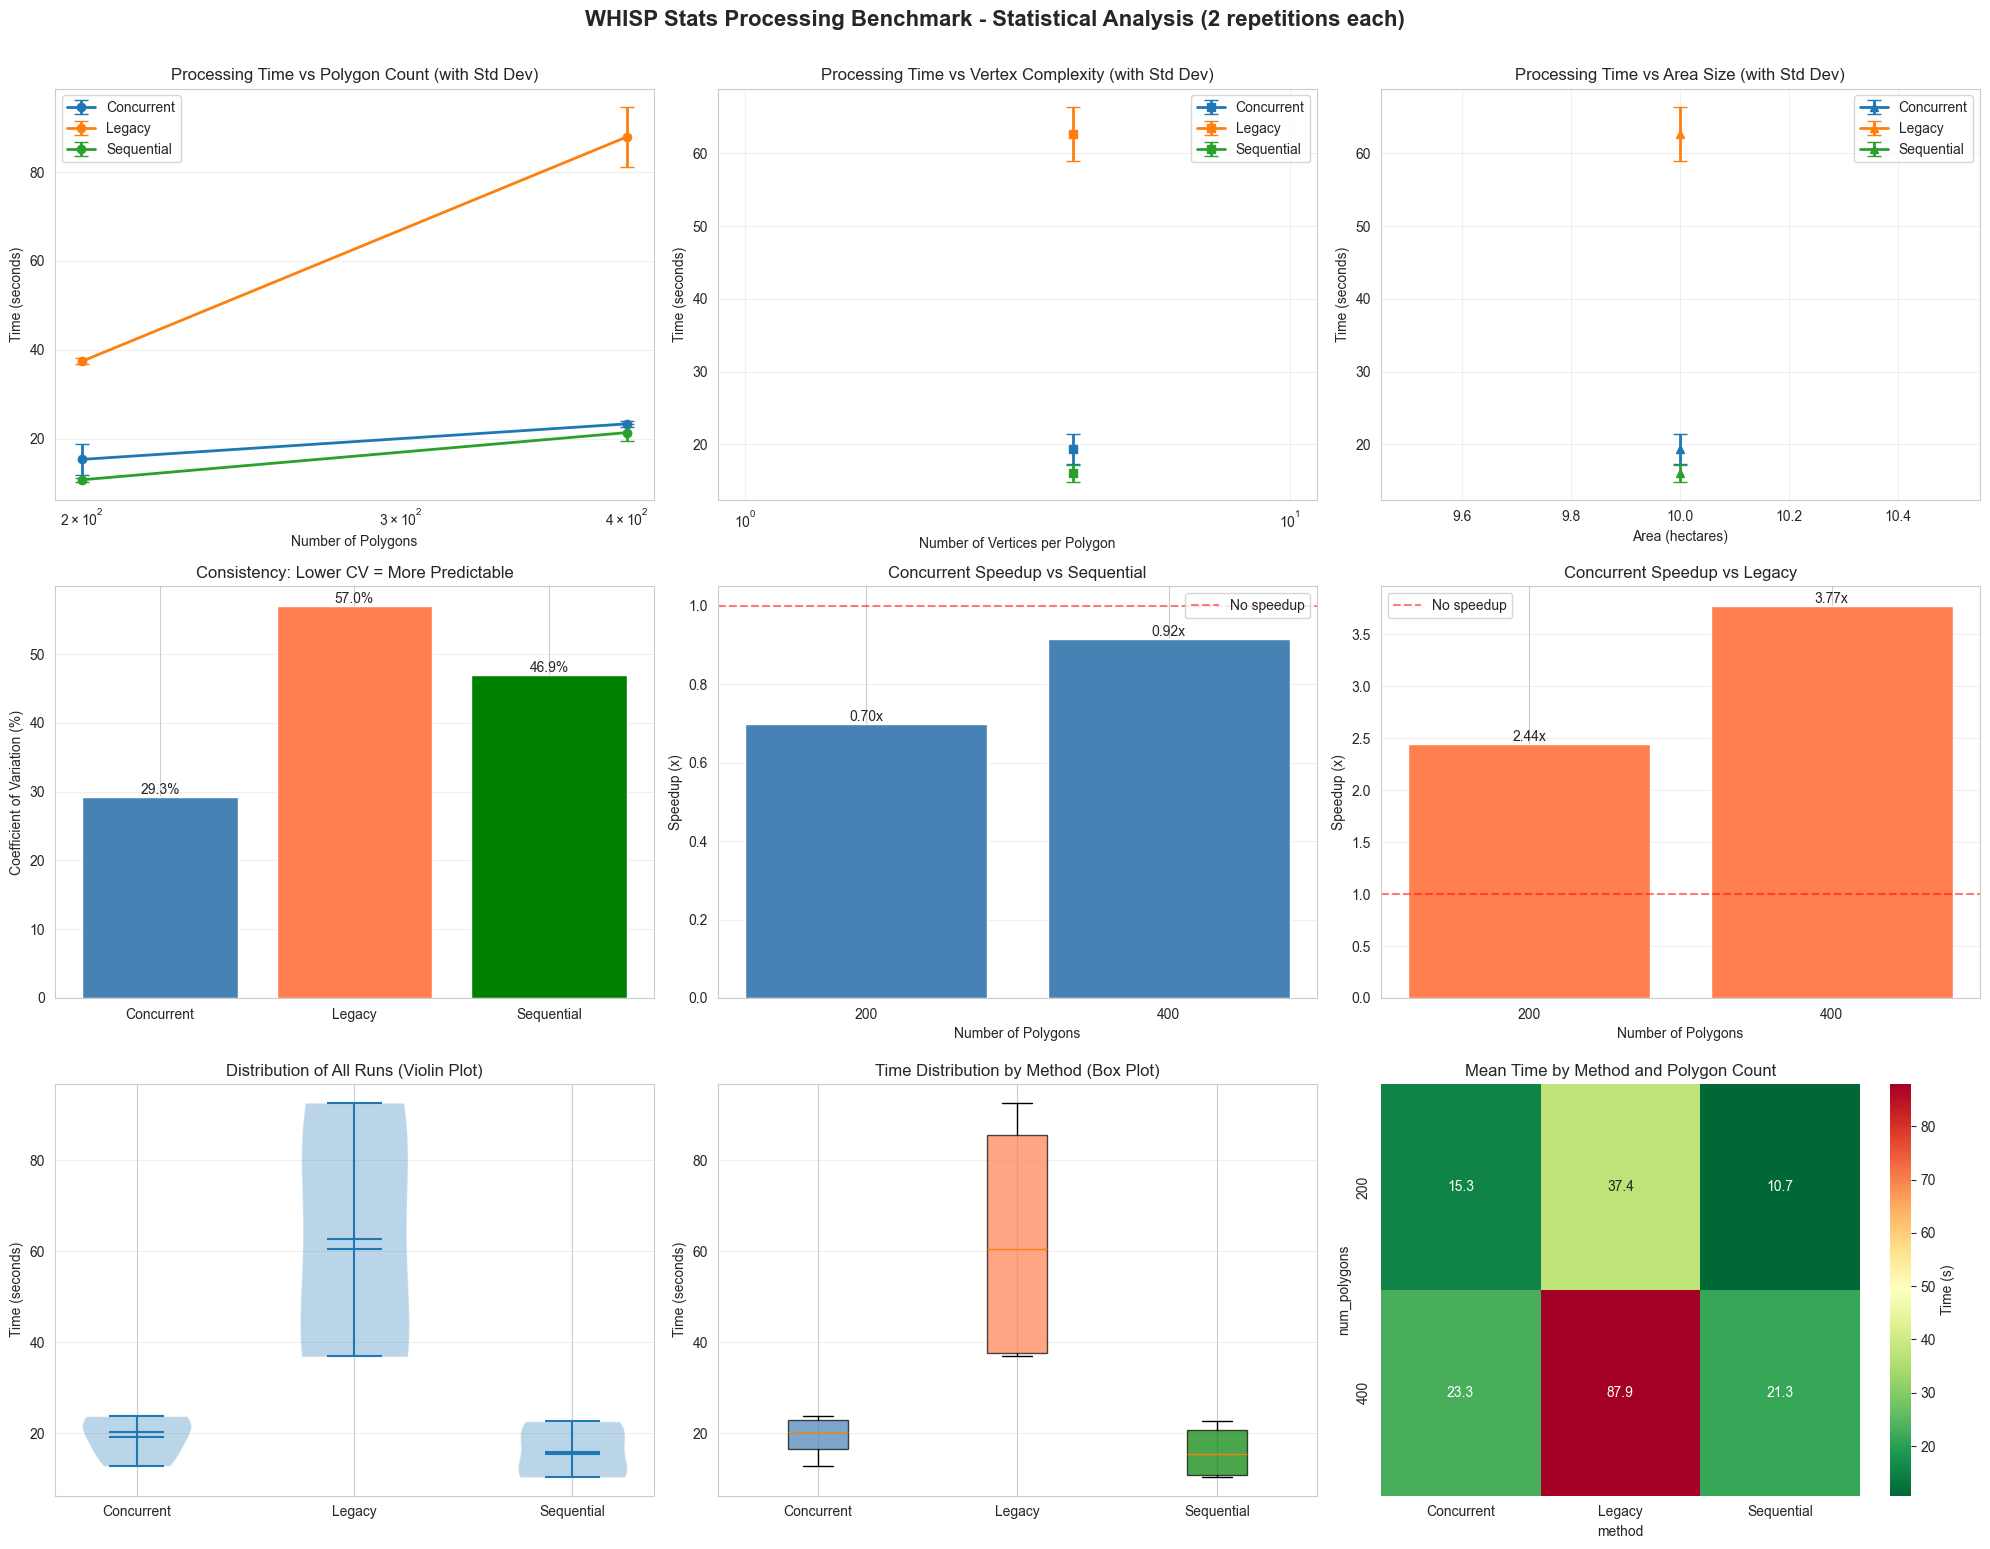

✅ Visualizations created


In [ ]:
# ============================================================================
# ANALYSIS 5: Visualizations (Including Error Bars from Repetitions)
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS 5: CREATING VISUALIZATIONS (with Error Bars)")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))

# 1. Time vs Polygon Count (with error bars)
ax1 = plt.subplot(3, 3, 1)
for method in sorted(df_averaged['method'].unique()):
    data = df_averaged[df_averaged['method'] == method].groupby('num_polygons').agg({
        'time_seconds_mean': 'mean',
        'time_seconds_std': 'mean'
    }).reset_index()
    ax1.errorbar(data['num_polygons'], data['time_seconds_mean'], 
                yerr=data['time_seconds_std'], marker='o', label=method, linewidth=2, capsize=5)
ax1.set_xlabel('Number of Polygons')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Processing Time vs Polygon Count (with Std Dev)')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Time vs Vertex Complexity (with error bars)
ax2 = plt.subplot(3, 3, 2)
for method in sorted(df_averaged['method'].unique()):
    data = df_averaged[df_averaged['method'] == method].groupby('num_vertices').agg({
        'time_seconds_mean': 'mean',
        'time_seconds_std': 'mean'
    }).reset_index()
    ax2.errorbar(data['num_vertices'], data['time_seconds_mean'], 
                yerr=data['time_seconds_std'], marker='s', label=method, linewidth=2, capsize=5)
ax2.set_xlabel('Number of Vertices per Polygon')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Processing Time vs Vertex Complexity (with Std Dev)')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Time vs Area Size (with error bars)
ax3 = plt.subplot(3, 3, 3)
for method in sorted(df_averaged['method'].unique()):
    data = df_averaged[df_averaged['method'] == method].groupby('area_ha').agg({
        'time_seconds_mean': 'mean',
        'time_seconds_std': 'mean'
    }).reset_index()
    ax3.errorbar(data['area_ha'], data['time_seconds_mean'], 
                yerr=data['time_seconds_std'], marker='^', label=method, linewidth=2, capsize=5)
ax3.set_xlabel('Area (hectares)')
ax3.set_ylabel('Time (seconds)')
ax3.set_title('Processing Time vs Area Size (with Std Dev)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Variability comparison (coefficient of variation)
ax4 = plt.subplot(3, 3, 4)
variability_data = []
for method in sorted(df_averaged['method'].unique()):
    method_times = df_averaged[df_averaged['method'] == method]['time_seconds_mean']
    cv = (method_times.std() / method_times.mean()) * 100
    variability_data.append({'Method': method, 'CV (%)': cv})
variability_df = pd.DataFrame(variability_data)
bars = ax4.bar(variability_df['Method'], variability_df['CV (%)'], color=['steelblue', 'coral', 'green'])
ax4.set_ylabel('Coefficient of Variation (%)')
ax4.set_title('Consistency: Lower CV = More Predictable')
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

# 5. Speedup vs Sequential
ax5 = plt.subplot(3, 3, 5)
speedup_by_polygons = df_speedup.groupby('num_polygons')['speedup_vs_sequential'].mean()
bars = ax5.bar(range(len(speedup_by_polygons)), speedup_by_polygons.values, color='steelblue')
ax5.set_xticks(range(len(speedup_by_polygons)))
ax5.set_xticklabels(speedup_by_polygons.index)
ax5.set_xlabel('Number of Polygons')
ax5.set_ylabel('Speedup (x)')
ax5.set_title('Concurrent Speedup vs Sequential')
ax5.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No speedup')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x', ha='center', va='bottom')

# 6. Speedup vs Legacy
ax6 = plt.subplot(3, 3, 6)
speedup_by_polygons_legacy = df_speedup.groupby('num_polygons')['speedup_vs_legacy'].mean()
bars = ax6.bar(range(len(speedup_by_polygons_legacy)), speedup_by_polygons_legacy.values, color='coral')
ax6.set_xticks(range(len(speedup_by_polygons_legacy)))
ax6.set_xticklabels(speedup_by_polygons_legacy.index)
ax6.set_xlabel('Number of Polygons')
ax6.set_ylabel('Speedup (x)')
ax6.set_title('Concurrent Speedup vs Legacy')
ax6.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No speedup')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x', ha='center', va='bottom')

# 7. Distribution of all runs (violin plot)
ax7 = plt.subplot(3, 3, 7)
parts = ax7.violinplot([df_all_results[df_all_results['method'] == m]['time_seconds'].values 
                        for m in sorted(df_all_results['method'].unique())],
                       positions=range(len(df_all_results['method'].unique())),
                       showmeans=True, showmedians=True)
ax7.set_xticks(range(len(df_all_results['method'].unique())))
ax7.set_xticklabels(sorted(df_all_results['method'].unique()))
ax7.set_ylabel('Time (seconds)')
ax7.set_title('Distribution of All Runs (Violin Plot)')
ax7.grid(True, alpha=0.3, axis='y')

# 8. Box plot by method
ax8 = plt.subplot(3, 3, 8)
box_data = [df_all_results[df_all_results['method'] == m]['time_seconds'].values 
            for m in sorted(df_all_results['method'].unique())]
bp = ax8.boxplot(box_data, labels=sorted(df_all_results['method'].unique()), patch_artist=True)
for patch, color in zip(bp['boxes'], ['steelblue', 'coral', 'green']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax8.set_ylabel('Time (seconds)')
ax8.set_title('Time Distribution by Method (Box Plot)')
ax8.grid(True, alpha=0.3, axis='y')

# 9. Heatmap: Mean time by Polygons and Method
ax9 = plt.subplot(3, 3, 9)
pivot_by_method = df_averaged.pivot_table(
    values='time_seconds_mean',
    index='num_polygons',
    columns='method',
    aggfunc='mean'
)
sns.heatmap(pivot_by_method, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax9, cbar_kws={'label': 'Time (s)'})
ax9.set_title('Mean Time by Method and Polygon Count')

plt.suptitle('WHISP Stats Processing Benchmark - Statistical Analysis ({} repetitions each)'.format(benchmark_params['num_repetitions']), 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

print("✅ Visualizations created")

In [ ]:
# ============================================================================
# EXPORT RESULTS (Raw Data + Summary Statistics)
# ============================================================================
print("\n" + "="*80)
print("EXPORTING RESULTS TO DOWNLOADS")
print("="*80)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Export raw results (all individual runs)
raw_df = df_all_results.copy()
raw_filename = downloads_path / f"benchmark_results_raw_{timestamp}.csv"
raw_df.to_csv(raw_filename, index=False)
print(f"\n💾 Raw results (all {len(raw_df)} runs): {raw_filename}")

# 2. Export averaged results (per configuration)
avg_export_df = df_averaged.copy()
avg_export_df = avg_export_df.sort_values(['method', 'num_polygons', 'num_vertices', 'area_ha'])
avg_filename = downloads_path / f"benchmark_results_averaged_{timestamp}.csv"
avg_export_df.to_csv(avg_filename, index=False)
print(f"💾 Averaged results ({len(avg_export_df)} configurations): {avg_filename}")

# 3. Export speedup analysis
speedup_filename = downloads_path / f"benchmark_speedup_analysis_{timestamp}.csv"
df_speedup.to_csv(speedup_filename, index=False)
print(f"💾 Speedup analysis: {speedup_filename}")

# Display summary statistics
print(f"\n📊 Results Summary:")
print(f"  Total raw test runs: {len(raw_df)}")
print(f"    - Concurrent:   {len(raw_df[raw_df['method'] == 'Concurrent'])}")
print(f"    - Sequential:   {len(raw_df[raw_df['method'] == 'Sequential'])}")
print(f"    - Legacy:       {len(raw_df[raw_df['method'] == 'Legacy'])}")
print(f"  Total configurations: {len(avg_export_df)}")
print(f"  Repetitions per config: {benchmark_params['num_repetitions']}")

print(f"\n📊 Output Directory:")
print(f"  📁 {downloads_path}")

print(f"\n📊 Raw Data Preview (first 10 runs):")
print(raw_df[['method', 'area_ha', 'num_polygons', 'num_vertices', 'repetition', 'time_seconds', 'status']].head(10).to_string(index=False))

print(f"\n📊 Averaged Data Preview (first 10 configs):")
print(avg_export_df[['method', 'area_ha', 'num_polygons', 'num_vertices', 'time_seconds_mean', 'time_seconds_std', 'time_seconds_count']].head(10).to_string(index=False))


EXPORTING RESULTS TO DOWNLOADS

💾 Raw results (all 12 runs): C:\Users\Arnell\Downloads\whisp_benchmarks\benchmark_results_raw_20251106_181706.csv
💾 Averaged results (6 configurations): C:\Users\Arnell\Downloads\whisp_benchmarks\benchmark_results_averaged_20251106_181706.csv
💾 Speedup analysis: C:\Users\Arnell\Downloads\whisp_benchmarks\benchmark_speedup_analysis_20251106_181706.csv

📊 Results Summary:
  Total raw test runs: 12
    - Concurrent:   4
    - Sequential:   4
    - Legacy:       4
  Total configurations: 6
  Repetitions per config: 2

📊 Output Directory:
  📁 C:\Users\Arnell\Downloads\whisp_benchmarks

📊 Raw Data Preview (first 10 runs):
    method  area_ha  num_polygons  num_vertices  repetition  time_seconds status
Concurrent       10           200             4           1     12.887450      ✅
Concurrent       10           200             4           2     17.707707      ✅
Concurrent       10           400             4           1     22.795340      ✅
Concurrent       10